In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

import lightgbm as lgb
import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

## Mean Target Encoding

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

## Paths

In [5]:
TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission19.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev6/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev6/val.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission19_val.feather')

## Load Data

In [6]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

CPU times: user 630 ms, sys: 415 ms, total: 1.05 s
Wall time: 4.9 s


## Feature Engineering

### Mean Target Encoding

In [7]:
%%time

# is_click
mte_click         = MeanTargetEncoding(['user_id'], target_name='is_click')
mte_click_encoded = cross_val_predict(mte_click, train, y=train.is_click, cv=5, n_jobs=-1)

user_click_mte = pd.DataFrame(mte_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# is_open

mte_open         = MeanTargetEncoding(['user_id'], target_name='is_open')
mte_open_encoded = cross_val_predict(mte_open, train, y=train.is_open, cv=5, n_jobs=-1)

user_open_mte = pd.DataFrame(mte_open_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# user_id, communication type
# train.loc[:, 'user_comm'] = train.user_id.astype(np.str) + '_' + train.communication_type.astype(np.str)

# mte_comm_click   = MeanTargetEncoding(['user_comm'], target_name='is_click')
# mte_comm_click_encoded = cross_val_predict(mte_comm_click, train, y=train.is_open, cv=5, n_jobs=-1)

# user_comm_click_mte = pd.DataFrame(mte_comm_click_encoded, 
#             columns=['%s_click_mte_mean'%col for col in ['user_comm']],
#             index=train.index.values
#             )

# generate for test
mte_click.fit(train, train.is_click)
mte_click_test_encoded = mte_click.predict(test)

mte_open.fit(train, train.is_open)
mte_open_test_encoded = mte_open.predict(test)

# test.loc[:, 'user_comm'] = test.user_id.astype(np.str) + '_' + test.communication_type.astype(np.str)
# mte_comm_click.fit(train, train.is_click)
# mte_comm_click_test_encoded = mte_click.predict(test)


user_click_test =  pd.DataFrame(mte_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

user_open_test =  pd.DataFrame(mte_open_test_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

# user_comm_click_test = pd.DataFrame(mte_comm_click_test_encoded, 
#             columns=['%s_click_mte_mean'%col for col in ['user_comm']],
#             index=test.index.values
#             )

train = pd.concat((train, user_click_mte, user_open_mte), axis=1)
test  = pd.concat((test, user_click_test, user_open_test), axis=1)

CPU times: user 46.3 s, sys: 3.59 s, total: 49.9 s
Wall time: 2min 9s


In [8]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

** Load interim dataset **

In [7]:
%%time

traintest = pd.read_feather(f'{INTERIM_PATH}')

CPU times: user 590 ms, sys: 622 ms, total: 1.21 s
Wall time: 7.8 s


### Text Based Features

In [9]:
%%time

tfidf  = TfidfVectorizer(stop_words='english')
bow    = tfidf.fit_transform(traintest.loc[:, 'subject'])

CPU times: user 26 s, sys: 563 ms, total: 26.6 s
Wall time: 26.7 s


### Other Features

In [10]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

user_age = traintest.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
traintest.loc[:, 'user_age'] = traintest.user_id.map(user_age)

digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

punctuation_pattern = re.compile(r'[.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

traintest.loc[:, 'click_to_open'] = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

CPU times: user 8min 10s, sys: 4.8 s, total: 8min 15s
Wall time: 8min 17s


In [11]:
%%time

traintest.index = np.arange(len(traintest))
traintest.to_feather(f'{INTERIM_PATH}')

CPU times: user 708 ms, sys: 381 ms, total: 1.09 s
Wall time: 4.11 s


In [10]:
FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_diff_email_types', 
            'most_sent_type', 'diff_hour', 'avg_diff_send_date',
            'user_id_click_mte_mean', 'user_id_open_mte_mean',
            'user_age','subject_num_digits', 'subject_has_punctuation',
            'click_to_open'
           ]

In [11]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type         0
send_day                   0
send_hour                  0
send_weekday               0
total_links                0
no_of_internal_links       0
no_of_images               0
no_of_sections             0
num_emails_sent            0
num_diff_email_types       0
most_sent_type             0
diff_hour                  0
avg_diff_send_date         0
user_id_click_mte_mean     0
user_id_open_mte_mean      0
user_age                   0
subject_num_digits         0
subject_has_punctuation    0
click_to_open              0
dtype: int64

In [12]:
%%time

traintest_text = sp.sparse.hstack((traintest.loc[:, FEATURES], bow), format='csr')

CPU times: user 2.55 s, sys: 1.13 s, total: 3.68 s
Wall time: 4.11 s


In [13]:
X_trn = traintest_text[:len(train)]
y_trn = traintest.iloc[:len(train)]['is_click'].values

X_val = traintest_text[len(train):]
y_val = traintest.iloc[len(train):]['is_click'].values

print(X_trn.shape, X_val.shape)

del traintest, traintest_text, bow
gc.collect();

(1023191, 216) (773858, 216)


## Validation

In [41]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn)
leval  = lgb.Dataset(X_val, y_val)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.728964	eval's auc: 0.705793
[40]	train's auc: 0.740059	eval's auc: 0.698811
[60]	train's auc: 0.748609	eval's auc: 0.707554
[80]	train's auc: 0.756676	eval's auc: 0.713431
[100]	train's auc: 0.762436	eval's auc: 0.712229
[120]	train's auc: 0.767452	eval's auc: 0.710824
[140]	train's auc: 0.772057	eval's auc: 0.70953
[160]	train's auc: 0.775355	eval's auc: 0.709119
[180]	train's auc: 0.777905	eval's auc: 0.707736
Early stopping, best iteration is:
[83]	train's auc: 0.757829	eval's auc: 0.714245


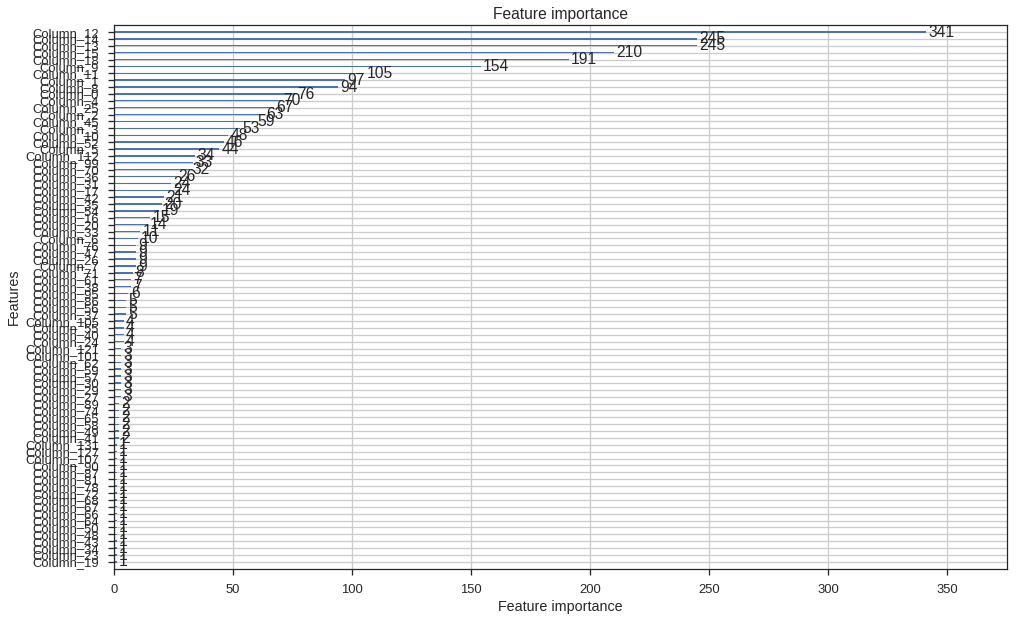

In [20]:
fig, ax = plt.subplots(1, figsize=(16, 10))
lgb.plot_importance(m, ax=ax);

## Full Training

In [14]:
%%time

params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(83 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

CPU times: user 52.2 s, sys: 129 ms, total: 52.3 s
Wall time: 14.6 s


## Submission

In [15]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission19.csv', index=False)